# MESQUAL 401: Folium Model Data Visualization - Areas, Points, and Lines

This notebook demonstrates how to visualize model DataFrames using MESQUAL's folium visualization system. We'll explore how to create interactive maps showing network topology, geographic data, and model properties across different geometric object types.

## Introduction

MESQUAL's folium visualization system provides a powerful way to create interactive geospatial visualizations of energy system data. In this notebook, we'll cover:

1. **Area Visualization**: Control areas and regions using AreaGenerator
2. **Point Visualization**: Buses and generators using CircleMarkerGenerator
3. **Line Visualization**: Transmission lines using LineGenerator
4. **Text Overlays**: Labels and annotations using TextOverlayGenerator
5. **PropertyMapper System**: Dynamic styling based on model properties

We'll use both external geospatial data (GeoJSON files) and integrated MESQUAL datasets with geographic information.

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

🖥️ Running locally. No setup needed.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let's go!")

✅ Environment ready. Let's go!


In [3]:
import os
import folium
import geopandas as gpd
import pandas as pd
import numpy as np

from mesqual import StudyManager
from mesqual_pypsa import PyPSADataset
from mesqual.visualizations.folium_viz_system import (
    PropertyMapper, 
    AreaGenerator, AreaFeatureResolver,
    CircleMarkerGenerator, CircleMarkerFeatureResolver,
    LineGenerator, LineFeatureResolver,
    TextOverlayGenerator, TextOverlayFeatureResolver
)
from mesqual.utils.folium_utils.background_color import set_background_color_of_map
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

# Register study-specific interpreters
from studies.study_01_intro_to_mesqual.src.study_specific_model_interpreters import (
    ControlAreaModelInterpreter, 
    ScigridDEBusModelInterpreter
)

PyPSADataset.register_interpreter(ControlAreaModelInterpreter)
PyPSADataset.register_interpreter(ScigridDEBusModelInterpreter)

configure_clean_output_for_jupyter_notebook()
renderer = ConditionalRenderer()

## Load Study Data

Let's load our PyPSA study data which includes networks with geographic information:

In [4]:
# Load the StudyManager with PyPSA Scigrid-DE network data
from studies.study_01_intro_to_mesqual.scripts.setup_study_manager import get_scigrid_de_study_manager
study = get_scigrid_de_study_manager()

# Get the base dataset for our visualizations
ds_base = study.scen.get_dataset('base')

print("Available data flags:")
for flag in sorted(ds_base.accepted_flags):
    if any(geo_term in flag for geo_term in ['control_areas', 'buses', 'lines']):
        print(f"  📍 {flag}")
    else:
        print(f"  📊 {flag}")

Available data flags:
  📍 buses
  📍 buses_t.marginal_price
  📍 buses_t.p
  📍 buses_t.q
  📍 buses_t.v_ang
  📍 buses_t.v_mag_pu
  📍 buses_t.v_mag_pu_set
  📊 carriers
  📍 control_areas
  📍 control_areas_t.vol_weighted_marginal_price
  📊 generators
  📊 generators_t.efficiency
  📊 generators_t.marginal_cost
  📊 generators_t.marginal_cost_quadratic
  📊 generators_t.mu_lower
  📊 generators_t.mu_p_set
  📊 generators_t.mu_ramp_limit_down
  📊 generators_t.mu_ramp_limit_up
  📊 generators_t.mu_upper
  📊 generators_t.p
  📊 generators_t.p_max_pu
  📊 generators_t.p_min_pu
  📊 generators_t.p_set
  📊 generators_t.q
  📊 generators_t.q_set
  📊 generators_t.ramp_limit_down
  📊 generators_t.ramp_limit_up
  📊 generators_t.stand_by_cost
  📊 generators_t.status
  📊 global_constraints
  📊 line_types
  📍 lines
  📍 lines_t.mu_lower
  📍 lines_t.mu_upper
  📍 lines_t.p0
  📍 lines_t.p1
  📍 lines_t.q0
  📍 lines_t.q1
  📍 lines_t.s_max_pu
  📊 links
  📊 links_t.efficiency
  📊 links_t.marginal_cost
  📊 links_t.marginal_c

## Part 1: Area Visualization - Control Areas

Let's start by visualizing control areas using both direct GeoJSON loading and the integrated MESQUAL dataset approach.

### Approach 1: Direct GeoJSON Loading

In [5]:
# Load control areas directly from GeoJSON file
geojson_path = 'studies/study_01_intro_to_mesqual/data/DE_control_areas.geojson'
control_areas_gdf = gpd.read_file(geojson_path)
control_areas_gdf = control_areas_gdf.rename(columns={'tso': 'control_area'})
control_areas_gdf = control_areas_gdf.set_index('control_area')
control_areas_gdf = control_areas_gdf.set_crs(epsg=4326)

print("Control Areas from GeoJSON:")
print(control_areas_gdf.head())
print(f"\nGeometry types: {control_areas_gdf.geometry.geom_type.unique()}")
print(f"CRS: {control_areas_gdf.crs}")

Control Areas from GeoJSON:
                                                       geometry
control_area                                                   
50Hertz       MULTIPOLYGON (((11.2639 50.48074, 11.2474 50.4...
TenneTDE      MULTIPOLYGON (((8.45592 50.41449, 8.38936 50.4...
TransnetBW    MULTIPOLYGON (((8.62585 47.64422, 8.59569 47.6...
Amprion       MULTIPOLYGON (((7.09992 49.15556, 7.0803 49.14...

Geometry types: ['MultiPolygon']
CRS: EPSG:4326


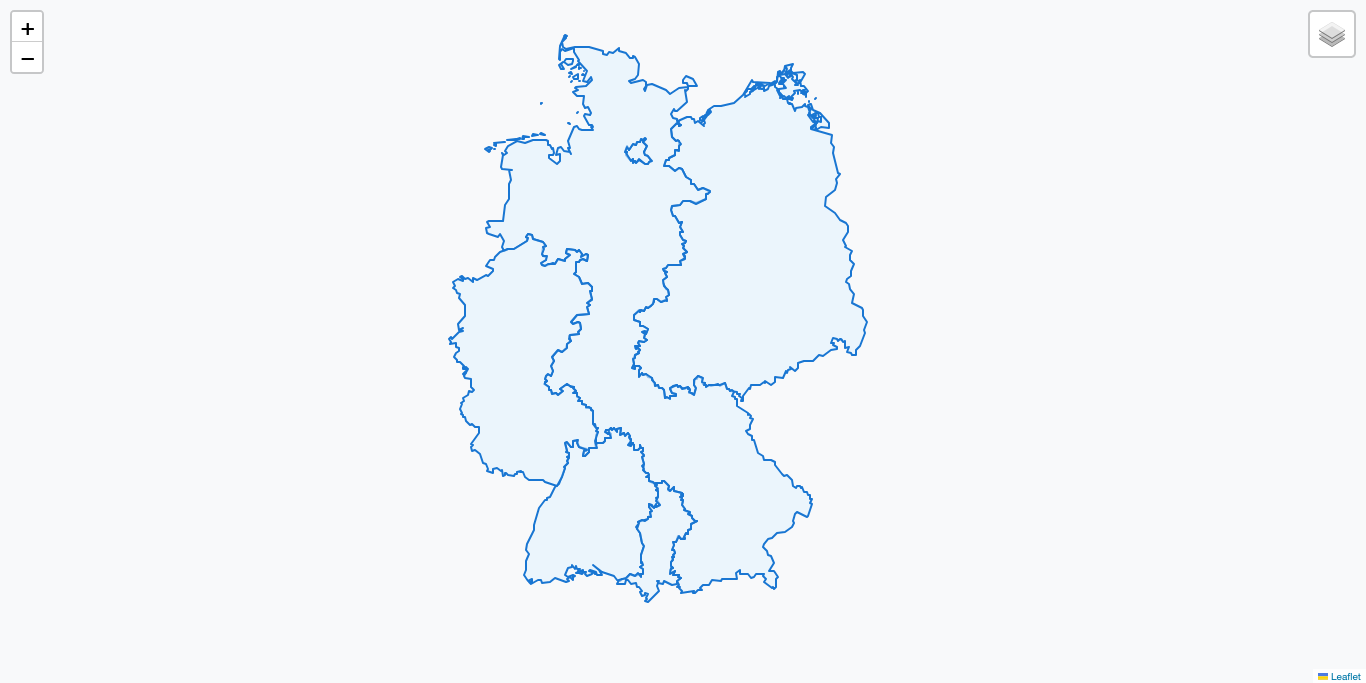

In [6]:
# Create a basic map with control areas
m1 = folium.Map(
    location=[51, 11],  # Center of Germany
    zoom_start=6,
    tiles=None
)
m1 = set_background_color_of_map(m1, color='#f8f9fa')

# Create a simple area generator with static styling
basic_area_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color='#e3f2fd',
        fill_opacity=0.6,
        border_color='#1976d2',
        border_width=2,
        tooltip=True  # Auto-generate tooltips from data
    )
)

# Create a feature group and add areas
feature_group = folium.FeatureGroup(name='Control Areas (Direct GeoJSON)')
basic_area_generator.generate_objects_for_model_df(control_areas_gdf, feature_group)
feature_group.add_to(m1)

folium.LayerControl().add_to(m1)
renderer.show_folium(m1)

### Approach 2: Using MESQUAL Dataset Integration

In [7]:
# Fetch control areas using MESQUAL dataset (via ControlAreaModelInterpreter)
control_areas_mesqual = ds_base.fetch('control_areas')

print("Control Areas from MESQUAL Dataset:")
print(control_areas_mesqual.head())
print(f"\nSame data? {control_areas_mesqual.equals(control_areas_gdf)}")

Control Areas from MESCAL Dataset:
                                                       geometry
control_area                                                   
50Hertz       MULTIPOLYGON (((11.2639 50.48074, 11.2474 50.4...
TenneTDE      MULTIPOLYGON (((8.45592 50.41449, 8.38936 50.4...
TransnetBW    MULTIPOLYGON (((8.62585 47.64422, 8.59569 47.6...
Amprion       MULTIPOLYGON (((7.09992 49.15556, 7.0803 49.14...

Same data? True


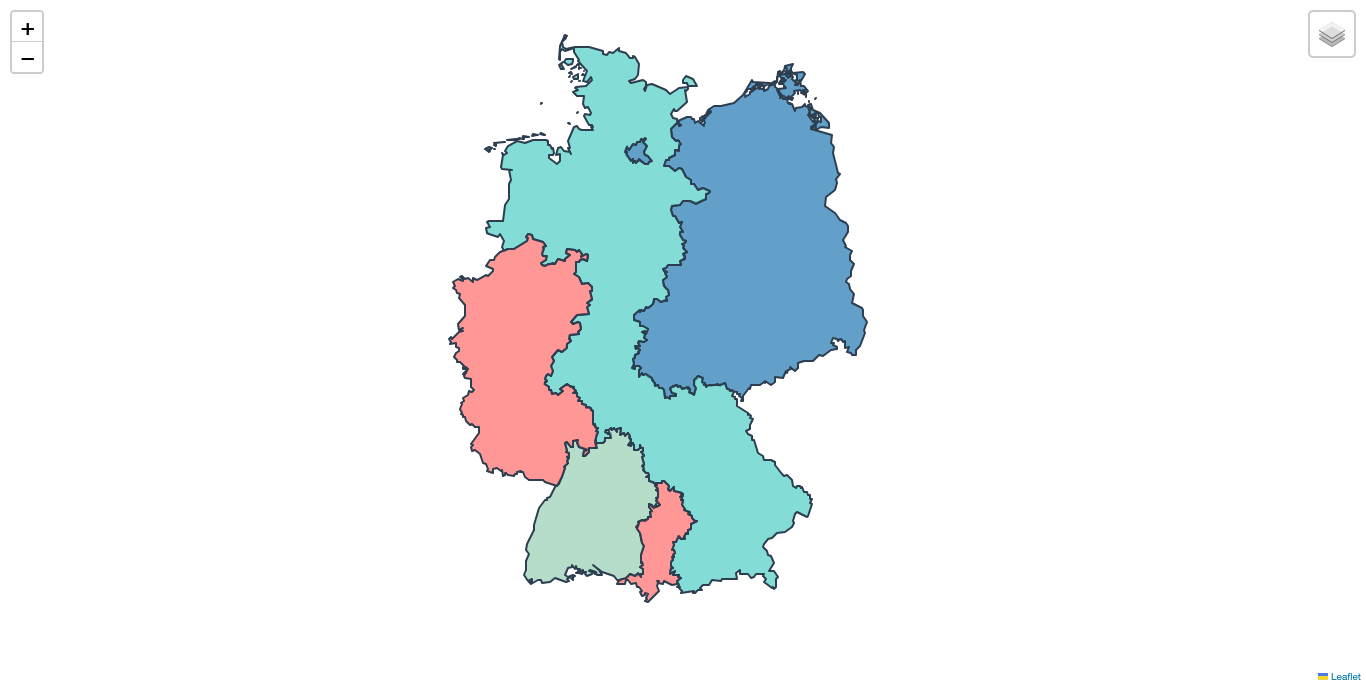

In [8]:
from mesqual.visualizations.value_mapping_system import DiscreteColorMapping

# Create a more sophisticated visualization with color mapping
m2 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m2 = set_background_color_of_map(m2, color='#ffffff')

# Define explicit colors for control areas
control_area_colors = {
    'Amprion': '#FF6B6B',      # Red
    'TenneTDE': '#4ECDC4',     # Teal  
    'TransnetBW': '#96CEB4',   # Blue
    # '50Hertz': '#45B7D1'     # outcommented to showcase the "auto_assign" feature of the DiscreteColorMapping class
}

#
control_areas_mesqual['fill_opacity'] = [1.0, 0.5, 1.0, 1.0]

color_mapping = DiscreteColorMapping(control_area_colors, mode="auto_assign")

# Create area generator with dynamic coloring
colored_area_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_item_attr('control_area', color_mapping),
        fill_opacity=0.7,
        border_color='#2c3e50',
        border_width=2,
        highlight_border_width=3,
        tooltip=True
    )
)

# Add colored areas
colored_feature_group = folium.FeatureGroup(name='Control Areas (Colored)')
colored_area_generator.generate_objects_for_model_df(control_areas_mesqual, colored_feature_group)
colored_feature_group.add_to(m2)

folium.LayerControl().add_to(m2)
renderer.show_folium(m2)

## Part 2: Point Visualization - Buses and Generators

Now let's visualize buses as points on the map, showing how the ScigridDEBusModelInterpreter enriches bus data with control area information.

In [9]:
# Fetch buses using MESQUAL (includes control area assignment via ScigridDEBusModelInterpreter)
buses_gdf = ds_base.fetch('buses')

print("Bus data structure:")
print(buses_gdf.head())
print(f"\nColumns: {list(buses_gdf.columns)}")
print(f"Geometry type: {buses_gdf.geometry.geom_type.unique()}")
print(f"Total buses: {len(buses_gdf)}")
print(f"Buses per control area:\n{buses_gdf['control_area'].value_counts()}")

Bus data structure:
     v_nom type      x  ...  ref                   location control_area
Bus                     ...                                             
1    220.0        9.52  ...        POINT (9.52258 52.36041)     TenneTDE
2    380.0        9.11  ...        POINT (9.11321 52.54385)     TenneTDE
3    380.0        9.39  ...        POINT (9.38975 52.02631)     TenneTDE
4    380.0        9.13  ...        POINT (9.12527 52.53826)     TenneTDE
5    380.0       10.37  ...       POINT (10.36627 52.28465)     TenneTDE

[5 rows x 21 columns]

Columns: ['v_nom', 'type', 'x', 'y', 'carrier', 'unit', 'v_mag_pu_set', 'v_mag_pu_min', 'v_mag_pu_max', 'control', 'generator', 'sub_network', 'frequency', 'wkt_srid_4326', 'operator', 'osm_name', 'voltage', 'typ', 'ref', 'location', 'control_area']
Geometry type: ['Point']
Total buses: 585
Buses per control area:
control_area
Amprion       241
TenneTDE      176
50Hertz        87
TransnetBW     81
Name: count, dtype: int64


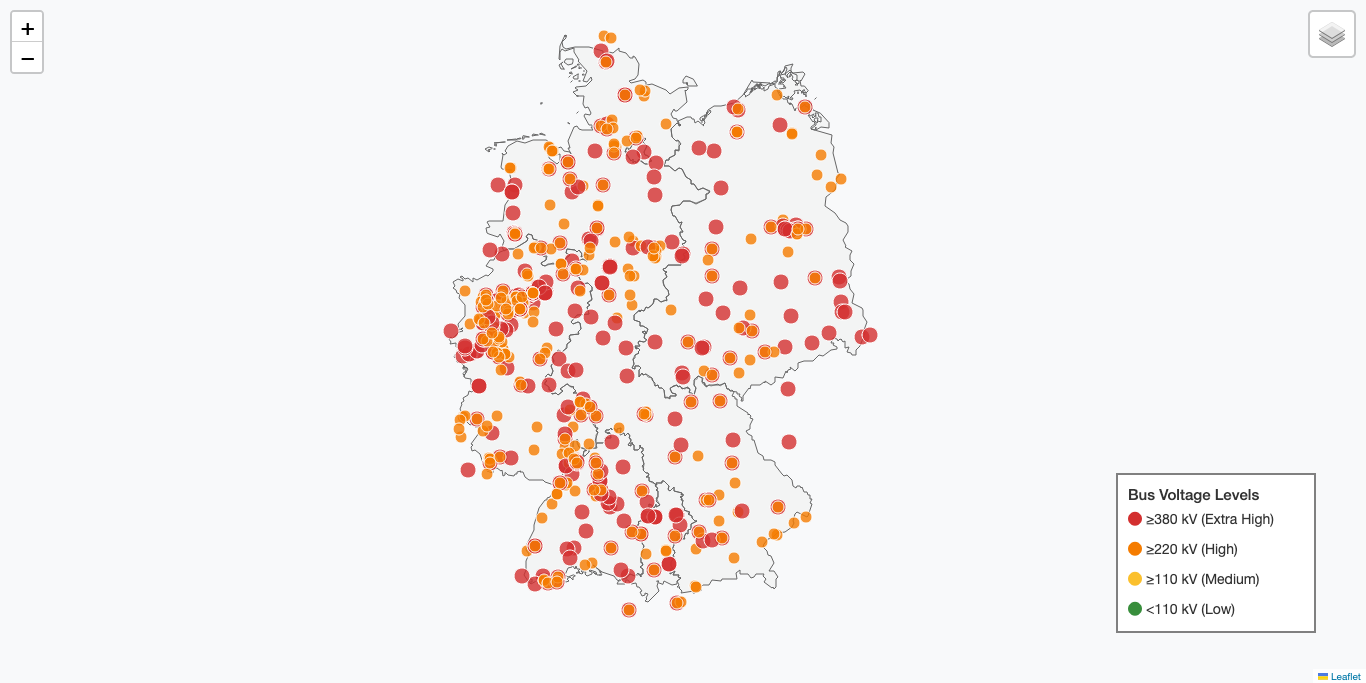

In [10]:
# Create map with buses as points
m3 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m3 = set_background_color_of_map(m3, color='#f8f9fa')

# Add control areas as background
bg_areas = folium.FeatureGroup(name='Control Areas (Background)')
basic_area_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_static_value('#e8e8e8'),
        fill_opacity=0.3,
        border_color=PropertyMapper.from_static_value('#666666'),
        border_width=1
    )
)
basic_area_generator.generate_objects_for_model_df(control_areas_mesqual, bg_areas)
bg_areas.add_to(m3)

# Function to get bus color based on voltage level
def get_bus_color_by_voltage(data_item):
    """Color buses by voltage level"""
    v_nom = data_item.get_object_attribute('v_nom')
    if v_nom >= 380:
        return '#d32f2f'  # Red for extra high voltage
    elif v_nom >= 220:
        return '#f57c00'  # Orange for high voltage  
    elif v_nom >= 110:
        return '#fbc02d'  # Yellow for medium voltage
    else:
        return '#388e3c'  # Green for low voltage

# Function to get bus size based on voltage level
def get_bus_size_by_voltage(data_item):
    """Size buses by voltage level"""
    v_nom = data_item.get_object_attribute('v_nom')
    if v_nom >= 380:
        return 8
    elif v_nom >= 220:
        return 6
    elif v_nom >= 110:
        return 4
    else:
        return 2

# Create circle marker generator for buses
bus_generator = CircleMarkerGenerator(
    CircleMarkerFeatureResolver(
        radius=PropertyMapper(get_bus_size_by_voltage),
        fill_color=PropertyMapper(get_bus_color_by_voltage),
        color=PropertyMapper.from_static_value('#2c3e50'),
        weight=1,
        fill_opacity=0.8,
        tooltip=True
    )
)

# Add buses to map
bus_feature_group = folium.FeatureGroup(name='Buses (by Voltage Level)')
bus_generator.generate_objects_for_model_df(buses_gdf, bus_feature_group)
bus_feature_group.add_to(m3)

# Add a custom legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 200px; height: 160px;
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px
            ">
<h4>Bus Voltage Levels</h4>
<p><i class="fa fa-circle" style="color:#d32f2f"></i> ≥380 kV (Extra High)</p>
<p><i class="fa fa-circle" style="color:#f57c00"></i> ≥220 kV (High)</p>
<p><i class="fa fa-circle" style="color:#fbc02d"></i> ≥110 kV (Medium)</p>
<p><i class="fa fa-circle" style="color:#388e3c"></i> <110 kV (Low)</p>
</div>
'''
m3.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl().add_to(m3)
renderer.show_folium(m3)

## Part 3: Line Visualization - Transmission Lines

Let's visualize the transmission lines connecting the buses in our network.

In [11]:
# Fetch transmission lines
lines_gdf = ds_base.fetch('lines')

print("Transmission lines data:")
print(lines_gdf.head())

Transmission lines data:
         bus0     bus1                         type  ...  bus_control_area_combo_opposite  bus_type_combo_opposite                                           geometry
Line                                                 ...                                                                                                             
1           1  2_220kV  Al/St 240/40 2-bundle 220.0  ...              TenneTDE - TenneTDE                       -   LINESTRING (9.52257596986 52.3604090558, 9.113...
2           3        4  Al/St 240/40 4-bundle 380.0  ...              TenneTDE - TenneTDE                       -   LINESTRING (9.38974509625 52.026313066, 9.1252...
3     5_220kV        6  Al/St 240/40 2-bundle 220.0  ...              TenneTDE - TenneTDE                       -   LINESTRING (10.3662749375 52.2846467462, 9.918...
4           7        5  Al/St 240/40 4-bundle 380.0  ...              TenneTDE - TenneTDE                       -   LINESTRING (9.91717971972 52.

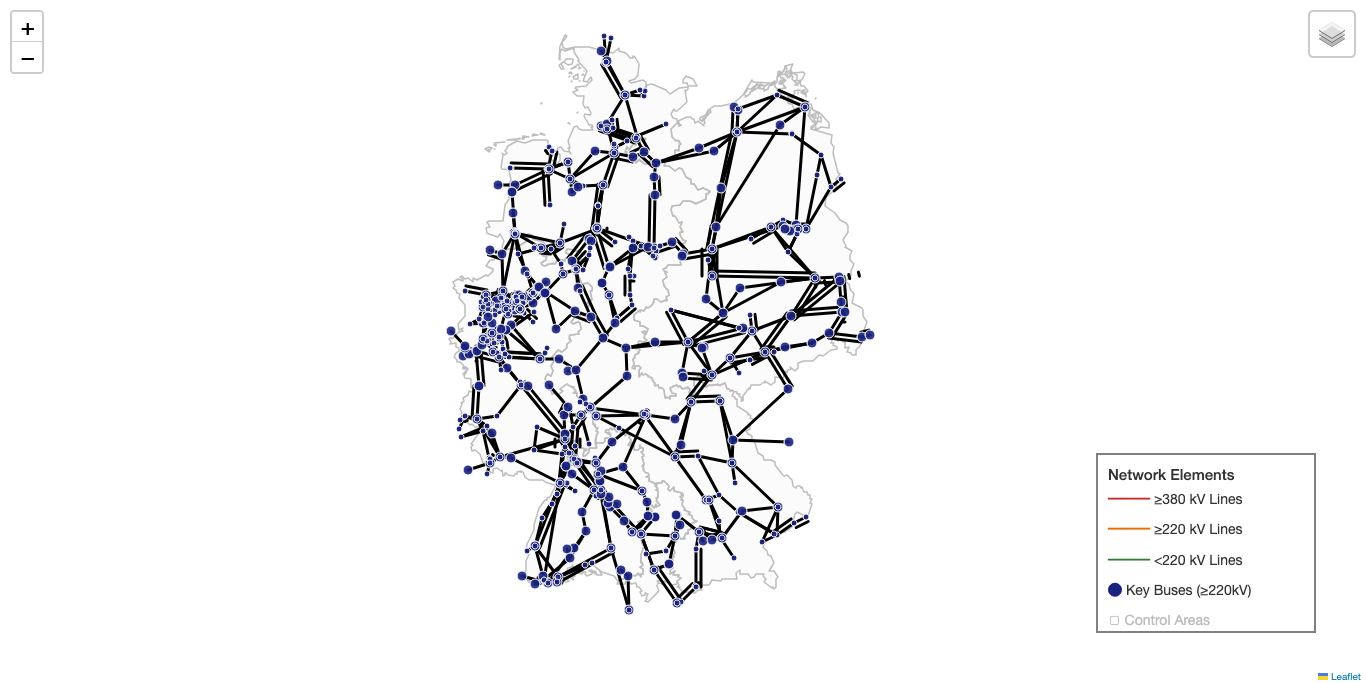

In [12]:
# Create comprehensive network visualization
m4 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m4 = set_background_color_of_map(m4, color='#ffffff')

# Add control areas as background (lighter)
bg_areas = folium.FeatureGroup(name='Control Areas')
area_bg_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_static_value('#f5f5f5'),
        fill_opacity=0.4,
        border_color=PropertyMapper.from_static_value('#bdbdbd'),
        border_width=1.5
    )
)
area_bg_generator.generate_objects_for_model_df(control_areas_mesqual, bg_areas)
bg_areas.add_to(m4)

# Function to style lines by voltage
def get_line_color_by_voltage(data_item):
    """Color lines by voltage level"""
    v_nom = data_item.get_object_attribute('v_nom')
    if v_nom >= 380:
        return '#c62828'  # Dark red for 380+ kV
    elif v_nom >= 220:
        return '#ef6c00'  # Orange for 220+ kV
    else:
        return '#2e7d32'  # Green for <220 kV

def get_line_width_by_voltage(data_item):
    """Width lines by voltage level"""
    v_nom = data_item.get_object_attribute('v_nom')
    if v_nom >= 380:
        return 4
    elif v_nom >= 220:
        return 3
    else:
        return 2

# Create line generator
line_generator = LineGenerator(
    LineFeatureResolver(
        color=PropertyMapper(get_line_color_by_voltage),
        weight=PropertyMapper(get_line_width_by_voltage),
        opacity=0.8,
        tooltip=True
    )
)

# Add transmission lines
lines_feature_group = folium.FeatureGroup(name='Transmission Lines')
line_generator.generate_objects_for_model_df(lines_gdf, lines_feature_group)
lines_feature_group.add_to(m4)

# Add key buses (high voltage only)
high_voltage_buses = buses_gdf[buses_gdf['v_nom'] >= 220]
key_bus_generator = CircleMarkerGenerator(
    CircleMarkerFeatureResolver(
        radius=PropertyMapper(lambda item: 5 if item.get_object_attribute('v_nom') >= 380 else 3),
        fill_color='#1a237e',
        color='#ffffff',
        weight=2,
        fill_opacity=0.9,
        tooltip=True
    )
)

key_buses_group = folium.FeatureGroup(name='Key Buses (≥220kV)')
key_bus_generator.generate_objects_for_model_df(high_voltage_buses, key_buses_group)
key_buses_group.add_to(m4)

# Add network legend
network_legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 220px; height: 180px;
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px
            ">
<h4>Network Elements</h4>
<p><span style="color:#c62828; font-weight:bold;">━━━</span> ≥380 kV Lines</p>
<p><span style="color:#ef6c00; font-weight:bold;">━━━</span> ≥220 kV Lines</p>
<p><span style="color:#2e7d32; font-weight:bold;">━━━</span> <220 kV Lines</p>
<p><i class="fa fa-circle" style="color:#1a237e"></i> Key Buses (≥220kV)</p>
<p style="color:#bdbdbd;">▢ Control Areas</p>
</div>
'''
m4.get_root().html.add_child(folium.Element(network_legend_html))

folium.LayerControl().add_to(m4)
renderer.show_folium(m4)

## Part 4: Text Overlays and Labels

Finally, let's add text overlays to label our control areas and key network elements.

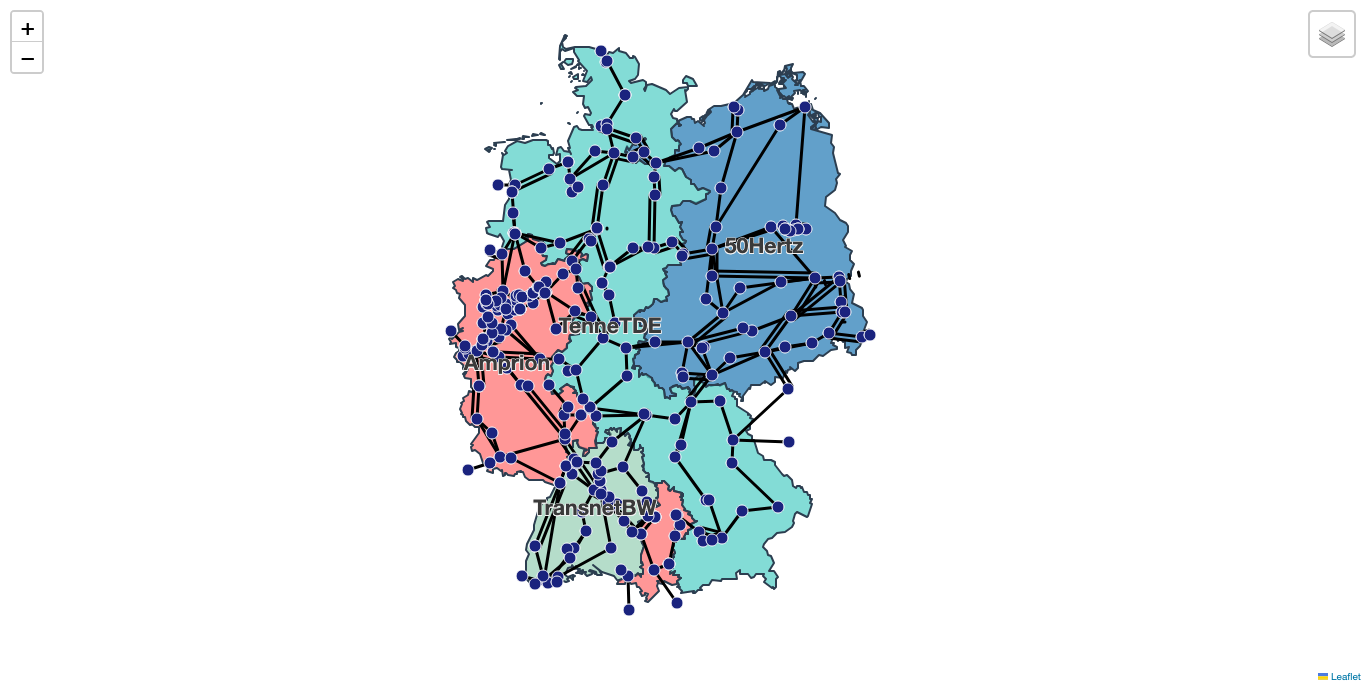

In [13]:
# Create final comprehensive map with text overlays
m5 = folium.Map(
    location=[51, 11],
    zoom_start=6,
    tiles=None
)
m5 = set_background_color_of_map(m5, color='#ffffff')

# Add colored control areas
areas_group = folium.FeatureGroup(name='Control Areas')
colored_area_generator.generate_objects_for_model_df(control_areas_mesqual, areas_group)
areas_group.add_to(m5)

# Add control area labels using TextOverlayGenerator
text_generator = TextOverlayGenerator(
    TextOverlayFeatureResolver(
        text=PropertyMapper.from_item_attr('control_area'),  # Use area name
        font_size='16pt',
        font_weight='bold',
        color='#2c3e50',
        background_color='#ffffff',
        border_color='#bdc3c7',
        border_width=1,
        padding=5
    )
)

labels_group = folium.FeatureGroup(name='Area Labels')
text_generator.generate_objects_for_model_df(control_areas_mesqual, labels_group)
labels_group.add_to(m5)

# Add transmission lines (extra high voltage only for cleaner view)
ehv_lines = lines_gdf[lines_gdf['v_nom'] >= 380]
ehv_line_generator = LineGenerator(
    LineFeatureResolver(
        color='#c62828',
        weight=3,
        opacity=0.8,
        tooltip=True
    )
)

ehv_lines_group = folium.FeatureGroup(name='Extra High Voltage Lines (≥380kV)')
ehv_line_generator.generate_objects_for_model_df(ehv_lines, ehv_lines_group)
ehv_lines_group.add_to(m5)

# Add major bus nodes
major_buses = buses_gdf[buses_gdf['v_nom'] >= 380]
major_bus_generator = CircleMarkerGenerator(
    CircleMarkerFeatureResolver(
        radius=6,
        fill_color=PropertyMapper.from_static_value('#1a237e'),
        color=PropertyMapper.from_static_value('#ffffff'),
        weight=2,
        fill_opacity=1.0,
        tooltip=True
    )
)

major_buses_group = folium.FeatureGroup(name='Major Bus Nodes (≥380kV)')
major_bus_generator.generate_objects_for_model_df(major_buses, major_buses_group)
major_buses_group.add_to(m5)

folium.LayerControl().add_to(m5)
renderer.show_folium(m5)

## Summary: PropertyMapper System

Throughout this notebook, we've demonstrated the power of MESQUAL's PropertyMapper system:

1. Static Values:

   PropertyMapper.from_static_value('#e3f2fd')

   → Always returns the same value

   → In the FeatureResolver, you can also set the feature attribute=static_value and the FeatureResolver will automatically create a static mapping.

2. Object Attributes and Attribute Mappings:

   PropertyMapper.from_item_attr('name')
   → Extracts 'name' attribute from data objects

   PropertyMapper.from_item_attr('name', custom_name_mapping_function)
   → Extracts 'name' attribute and maps it through custom_name_mapping_function

3. Custom Functions:

   PropertyMapper(get_area_color)
   → Applies custom logic directly to the data-item to determine properties and map them according to your logic. Especially useful when you have conditional logic, like if object_value > object_threshold then ... else ...

4. Default Mappers:

   → Geometries, text content, and other feature-properties will be intelligently generated based on default if no specifics are defined

5. Dynamic Styling Examples:
   - Bus colors/sizes based on voltage levels
   - Line colors/widths based on voltage levels
   - Area colors based on control area names
   - Text labels from object attributes

## Conclusion

In this notebook, we've explored MESQUAL's folium visualization system for model DataFrames:

### Key Concepts Covered:

1. **Multiple Data Sources**: Both direct GeoJSON loading and integrated MESQUAL datasets
2. **Object Type Visualization**:
   - **Areas**: Control regions with AreaGenerator
   - **Points**: Buses and generators with CircleMarkerGenerator  
   - **Lines**: Transmission lines with LineGenerator
   - **Text**: Labels and annotations with TextOverlayGenerator

3. **PropertyMapper System**: Dynamic styling based on data attributes
4. **FeatureResolver Pattern**: Configurable styling and behavior
5. **Layer Management**: Organized visualization with folium FeatureGroups

### Next Steps:

In the next notebook (mesqual_304), we'll explore how to visualize KPI data using the same system, showing how computed metrics can be mapped to geographic visualizations with automatic coloring, legends, and interactive features.

### Key Takeaways:

- MESQUAL's folium system provides a unified approach to geospatial visualization
- The PropertyMapper system enables highly flexible, data-driven styling
- Integration with MESQUAL datasets allows seamless visualization of model data
- Multiple object types can be combined to create comprehensive network visualizations